# Ames Housing Prices

### Regression and Classification with the Ames Housing Data

---

In this notebook, I plan to show how to clean, explore, analyze and predict home prices based on permanent house qualities and renovatable qualities. For example, the shape of the lot can;t be fixed, but teh quality of the basement can.

This notebook uses [data from Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [37]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Load and Feature Engineer

In [38]:
# Load the data
df = pd.read_csv('./housing.csv')
#keep NA as NA for dummies

In [39]:
# create total sq feet var

df['total_sqft'] = df['TotalBsmtSF'] + df['GarageArea'] + df['GrLivArea']
df['home_lot_sqft_ratio'] = df['total_sqft'] / df['LotArea']
# this ratio turned out to be fairly useless

### Clean Data

In [40]:
# remove all C (meaning commercial) properties
df = df[df['MSZoning'] != 'C (all)']

# turn ms subclass into object, not int
df['MSSubClass'] = df['MSSubClass'].astype('category')

In [41]:
# fill nan values with median
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['GarageYrBlt'].median())
df['MasVnrArea'] = df['MasVnrArea'].fillna(df['MasVnrArea'].median())
df['LotFrontage']= df['LotFrontage'].fillna(df['LotFrontage'].median())

### EDA Plots

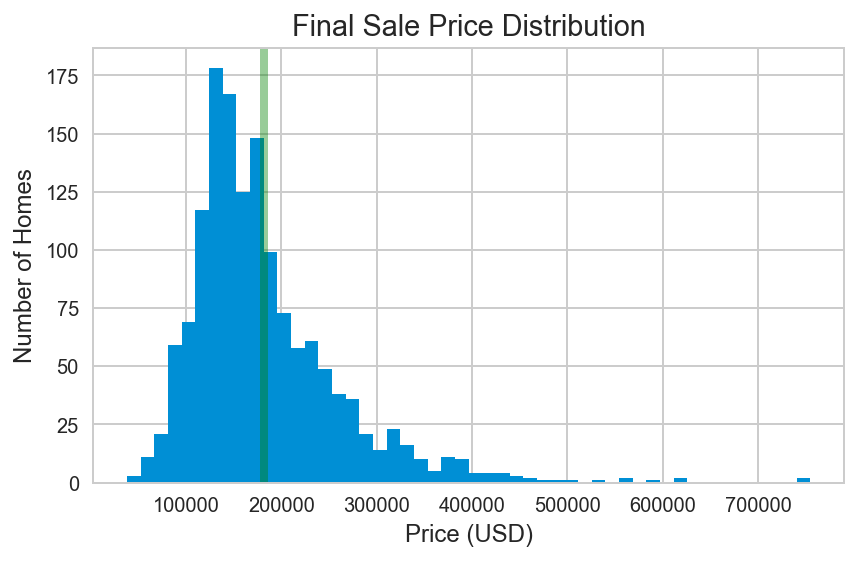

In [42]:
# Sale Price Distribution


plt.axvline(df['SalePrice'].mean(), c = 'g', alpha = .4)
df['SalePrice'].hist(bins = 50)
plt.xlabel('Price (USD)')
plt.ylabel('Number of Homes')
plt.title('Final Sale Price Distribution')

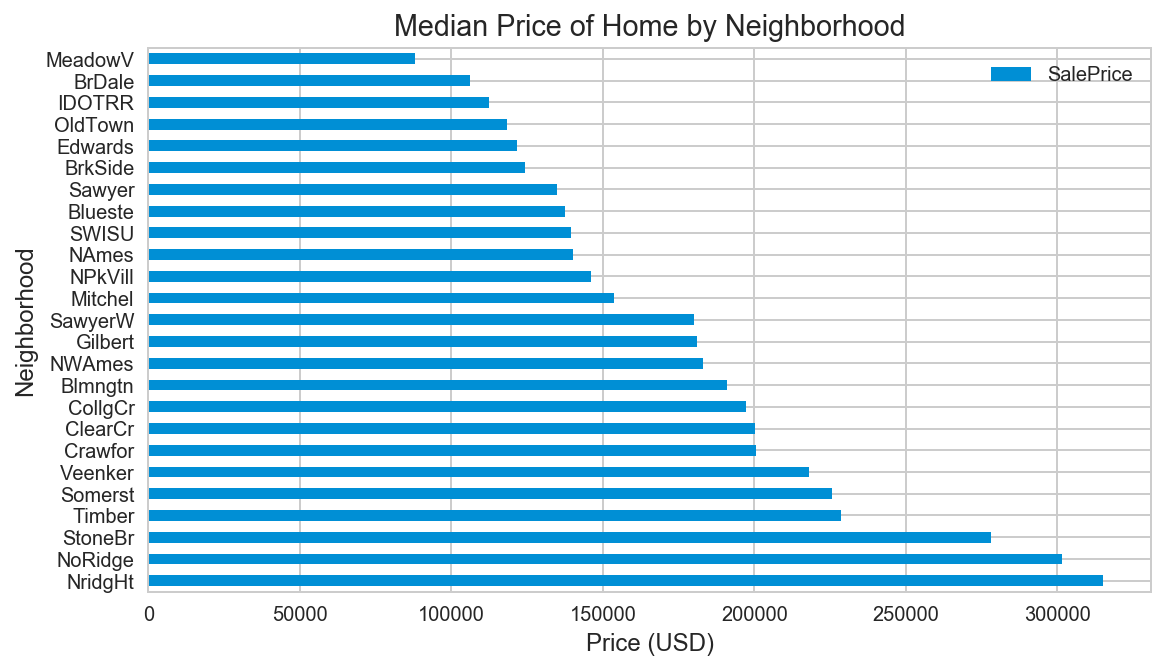

In [43]:
# plot median price by neighborhood
a = pd.DataFrame(df.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending = False))
a.plot.barh(figsize = (8,5))
plt.xlabel('Price (USD)')
plt.title('Median Price of Home by Neighborhood')

## Create a model on fixed features only
Use training data, then test it on houses sold after 2010

In [44]:
from sklearn import linear_model

### Model on all Dummy vars

In [45]:
dums = pd.get_dummies(df[['Neighborhood', 'Street', 'LotShape', 'Utilities', 'LandContour', 'LotConfig',
                          'LandSlope', 'MSZoning', 'MSSubClass', 'Condition1', 'Condition2', 'BldgType',
                          'HouseStyle']], 
                      dummy_na=True, drop_first=True)

# combine dummies with features
df_dums = pd.concat([df[['SalePrice', 'total_sqft', 'LotArea', 'home_lot_sqft_ratio', 'YrSold']], dums], axis=1)
df_dums.shape


(1450, 99)

In [46]:
# split data to train and test
## pre 2010 and 2010

test = df_dums[df_dums['YrSold'] == 2010]
train = df_dums[df_dums['YrSold'] < 2010]

print train.shape, test.shape

X_train = train.iloc[:, train.columns != 'SalePrice'] 
y_train = train['SalePrice']
X_test = test.iloc[:, test.columns != 'SalePrice']
y_test = test['SalePrice']

# Scale data
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(X_train)

# Transform train and test
Xs = ss.transform(X_train)
X_test_s = ss.transform(X_test)

### linear model on all dummies

lm = linear_model.LinearRegression()
model = lm.fit(Xs, y_train)

print model.score(Xs, y_train)


# find the top variable by absolute value of beta
a = pd.DataFrame(zip(X_train.columns, model.coef_), columns = ['var', 'beta'])
a['abs_beta'] = abs(a['beta'])
a[a['abs_beta'] > 0].sort_values('abs_beta', ascending = False).head(10)


(1278, 99) (172, 99)
0.801891294999


,var,beta,abs_beta
67,MSSubClass_nan,-3.172153e+17,3.172153e+17
30,Street_nan,-2.692416e+17,2.692416e+17
76,Condition1_nan,-2.631221e+17,2.631221e+17
52,MSZoning_nan,-2.497956e+17,2.497956e+17
48,LandSlope_nan,-2.440485e+17,2.440485e+17
34,LotShape_nan,-2.270720e+17,2.270720e+17
28,Neighborhood_nan,-2.236536e+17,2.236536e+17
45,LotConfig_nan,-1.617190e+17,1.617190e+17
36,Utilities_nan,-1.410558e+17,1.410558e+17
40,LandContour_nan,-9.163316e+16,9.163316e+16


### Test the dummies model

In [47]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lm, Xs, y_train, cv = 10)
print scores
print scores.mean(), scores.std()


[  8.46027986e-01   7.85448362e-01   8.37397622e-01  -2.80631366e+26
   7.74437812e-01  -9.19151229e+24  -4.42115447e+26   7.39969590e-01
  -2.50186823e+25   8.19483478e-01]
-7.56957007602e+25 1.47523577588e+26


In [48]:
# test model

predicted = model.predict(X_test_s)

from sklearn.metrics import mean_squared_error
print model.score(X_test_s, y_test)

print mean_squared_error(y_test, predicted)


0.820773298584
1139415670.67


0.820773298584


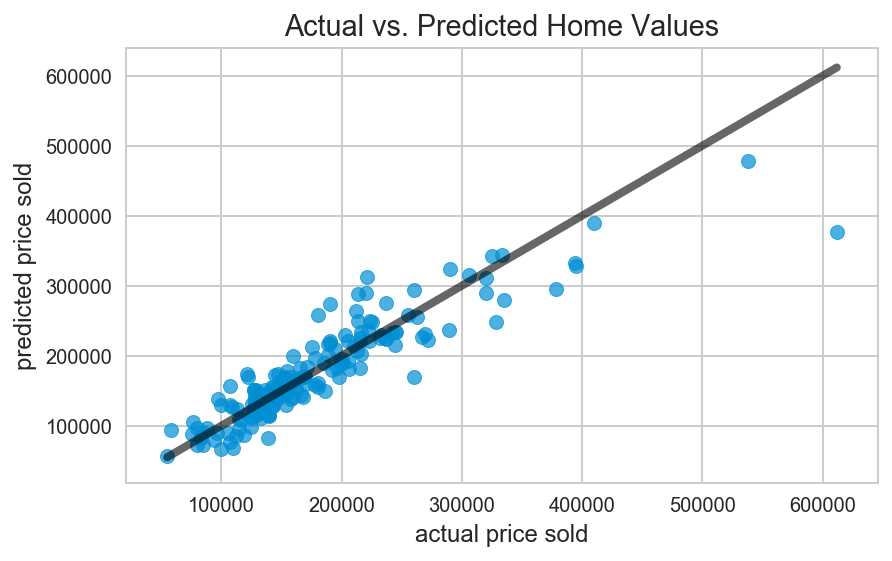

In [49]:
# plot the dummy model

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(y_test, predicted, alpha = .7)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted Home Values')

print model.score(X_test_s, y_test)

In [50]:
# The higher end prices seem to be way below what the model predicts the price be.

In [51]:
# get resids on all data
resid_all = model.predict(ss.transform(df_dums.drop('SalePrice', axis = 1))) - df_dums['SalePrice'].values

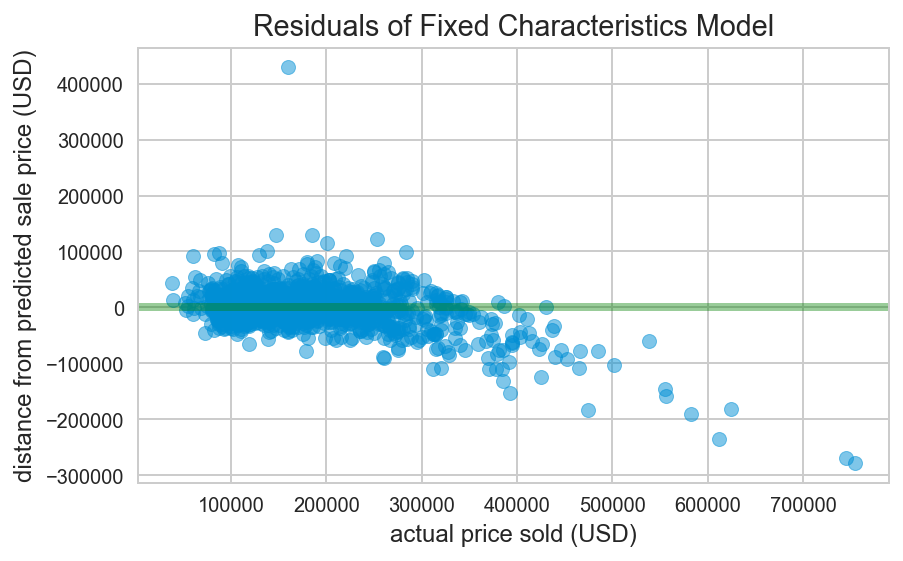

In [52]:
plt.axhline(c = 'g', alpha = .4)
plt.scatter(df['SalePrice'], resid_all, alpha = .5)
plt.title('Residuals of Fixed Characteristics Model')
plt.xlabel('actual price sold (USD)')
plt.ylabel('distance from predicted sale price (USD)')

### Regularization
Feature selection

In [53]:
## Feature selection on all Dummies

### Use Grid Search to see if I should use Lasso or Ridge

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

en = ElasticNet()

param_grid = {'l1_ratio': np.linspace(0, 1, 92)}

grid_en = GridSearchCV(ElasticNet(), param_grid)
grid_en_fit = grid_en.fit(Xs, y_train)

grid_en_fit.best_params_

# best l1 ratio is close to 1, meaning use lasso instead of ridge

{'l1_ratio': 0.89010989010989017}

In [54]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv = 5)
lasso.fit(Xs, y_train)

lasso.score(X_test_s, y_test)


0.82177560122058035

0.821775601221


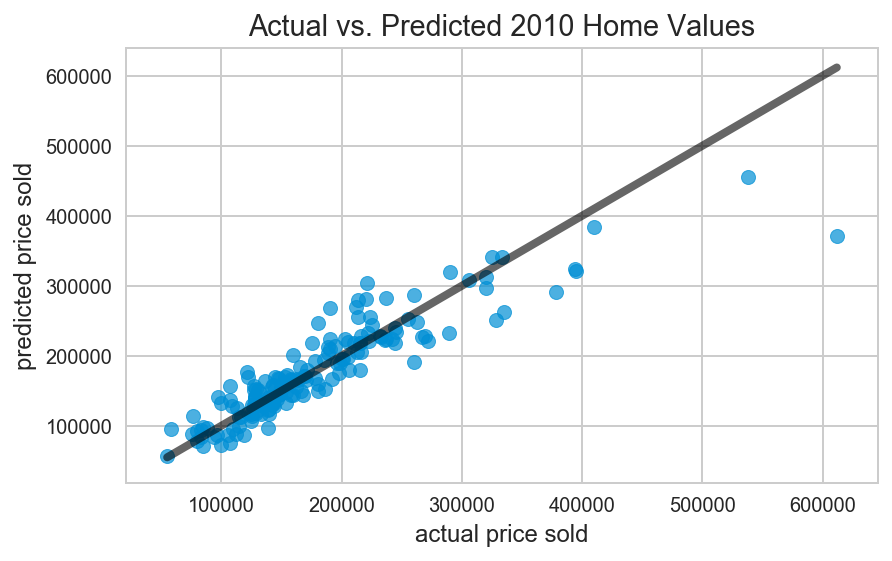

In [55]:
lasso_pred = lasso.predict(X_test_s)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(y_test, lasso_pred, alpha = .7)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted 2010 Home Values')

print lasso.score(X_test_s, y_test)

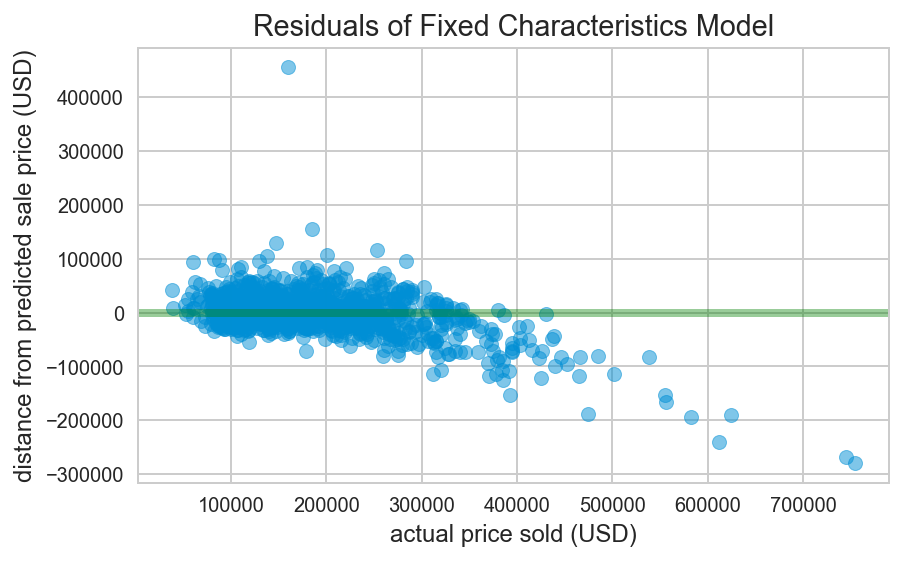

In [56]:
# lasso residuals of all data
resid_lasso_all = lasso.predict(ss.transform(df_dums.drop('SalePrice', axis = 1))) - df_dums['SalePrice'].values

plt.axhline(c = 'g', alpha = .4)
plt.scatter(df['SalePrice'], resid_lasso_all, alpha = .5)
plt.title('Residuals of Fixed Characteristics Model')
plt.xlabel('actual price sold (USD)')
plt.ylabel('distance from predicted sale price (USD)')

In [57]:
#find vars with low coef after Lasso

a = pd.DataFrame(zip(X_train.columns, lasso.coef_), columns = ['var', 'beta'])
a['abs_beta'] = abs(a['beta'])

fixed_vars_lasso = list(a[abs(a['beta']) > 0].sort_values('abs_beta', ascending = False)['var'].values)
a[abs(a['beta']) > 0].sort_values('abs_beta', ascending = False).head(10)

,var,beta,abs_beta
0,total_sqft,45461.765924,45461.765924
19,Neighborhood_NridgHt,16658.644189,16658.644189
18,Neighborhood_NoRidge,10122.380213,10122.380213
25,Neighborhood_StoneBr,9063.543608,9063.543608
15,Neighborhood_NAmes,-7131.800119,7131.800119
24,Neighborhood_Somerst,6941.669304,6941.669304
20,Neighborhood_OldTown,-6330.319644,6330.319644
57,MSSubClass_60.0,6200.939594,6200.939594
10,Neighborhood_Edwards,-5239.818594,5239.818594
62,MSSubClass_90.0,-3995.942399,3995.942399


In [58]:
## Neighborhood dummies are 7 of top 10

## Explore Renovatable Features of housing

### Read in, clean, select renovatable features

In [59]:
# A:
ames = pd.read_csv('./housing.csv', verbose=True, keep_default_na=False)
#keep NA as NA, not np.nan values

Tokenization took: 9.09 ms
Type conversion took: 11.81 ms
Parser memory cleanup took: 0.01 ms


In [60]:
renovatable = ['OverallQual', 'OverallCond', 'Utilities', 'RoofMatl', 'RoofStyle',
               'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'MoSold',
               'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
               'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
               'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
               'PoolQC', 'SalePrice']

ames_reno = ames[renovatable]

### EDA Plotting

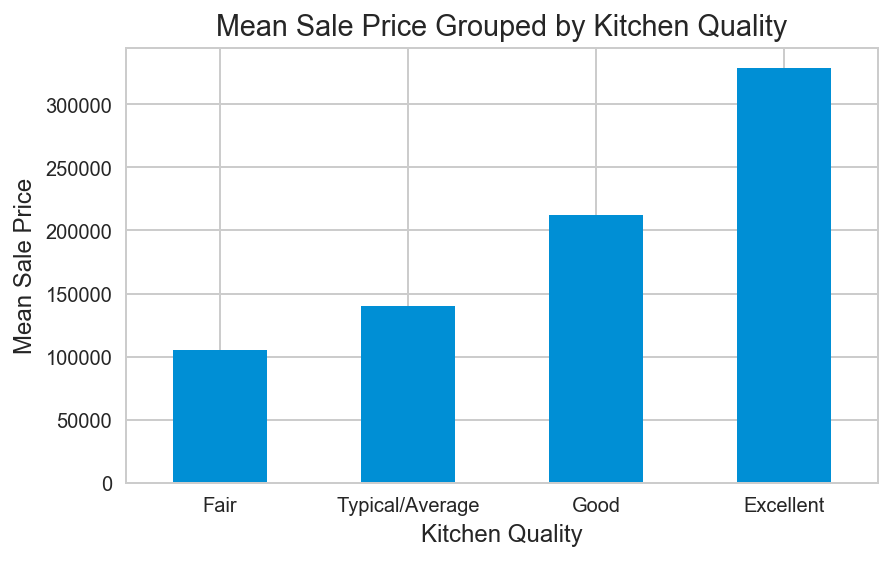

In [61]:

ames_reno.groupby('KitchenQual')['SalePrice'].mean().sort_values().plot(kind='bar')
plt.title('Mean Sale Price Grouped by Kitchen Quality')
plt.xlabel('Kitchen Quality')
plt.ylabel('Mean Sale Price')
plt.xticks(range(4), ['Fair', 'Typical/Average', 'Good', 'Excellent'], rotation = 0);

In [62]:
ames_reno.groupby('KitchenQual')['SalePrice'].mean().sort_values()

KitchenQual
Fa    105565.205128
TA    139962.511565
Gd    212116.023891
Ex    328554.670000
Name: SalePrice, dtype: float64

## Model on renovatable features

In [63]:
dums_reno = pd.get_dummies(ames[['Utilities', 'RoofMatl', 'RoofStyle',
                        'ExterQual', 'ExterCond', 'BsmtCond', 'BsmtFinType1', 'MoSold',
                        'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
                        'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu',
                        'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']], 
                      dummy_na=True, drop_first=True)

# combine dummies with features
df_dums_reno = pd.concat([ames[['SalePrice', 'OverallQual', 'OverallCond', 'YrSold']], dums_reno], axis=1)
df_dums_reno.head()

,SalePrice,OverallQual,OverallCond,YrSold,MoSold,Utilities_NoSeWa,Utilities_nan,RoofMatl_CompShg,RoofMatl_Membran,RoofMatl_Metal,...,GarageQual_nan,GarageCond_Fa,GarageCond_Gd,GarageCond_NA,GarageCond_Po,GarageCond_TA,GarageCond_nan,PavedDrive_P,PavedDrive_Y,PavedDrive_nan
0,208500,7,5,2008,2,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,181500,6,8,2007,5,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
2,223500,7,5,2008,9,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,140000,7,5,2006,2,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,250000,8,5,2008,12,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0


In [64]:
# split data to train and test
## pre 2010 and 2010

train = df_dums_reno[df_dums_reno['YrSold'] < 2010]
test = df_dums_reno[df_dums_reno['YrSold'] == 2010]

print train.shape, test.shape

X_train = train.iloc[:, train.columns != 'SalePrice'] 
y_train = train['SalePrice']
X_test = test.iloc[:, test.columns != 'SalePrice']
y_test = test['SalePrice']

(1285, 104) (175, 104)


In [65]:
### linear model on all renovatable dummies

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

print model.score(X_train, y_train)

0.745047149343


In [66]:
#create predicted vars
predicted = model.predict(X_test)
max(predicted)

16216890262786916.0

In [67]:
# remove crazy high prediction outlier

test['predicted'] = predicted
test2 = test[test['predicted'] != max(predicted)]

/Users/alexfreeman/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


0.748140419936


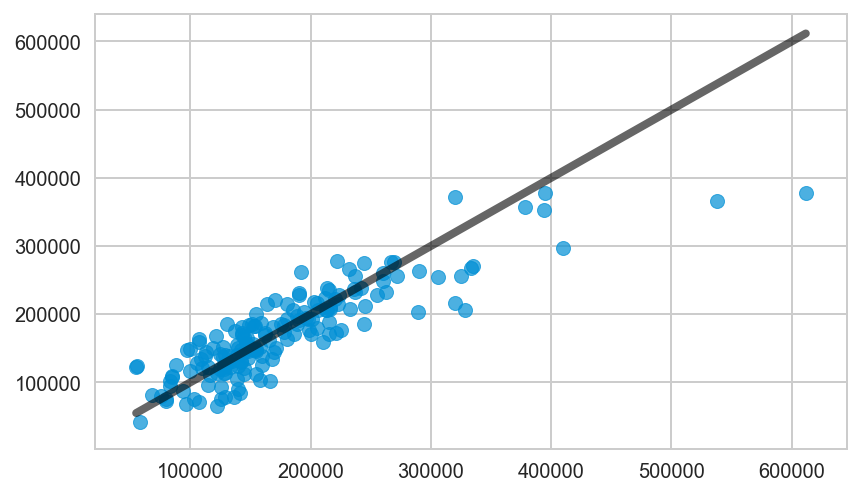

In [68]:
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(test2['SalePrice'], test2['predicted'], alpha = .7)

print model.score(test2.drop(['predicted', 'SalePrice'], axis = 1), test2['SalePrice'])

# model score is ...ok. but worse than fixed model

### Feature Selection

In [48]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv = 5)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [49]:
#find vars with low coef after Lasso

a = pd.DataFrame(zip(X_train.columns, lasso.coef_), columns = ['var', 'beta'])
a['abs_beta'] = abs(a['beta'])
a[abs(a['beta']) > 0].sort_values('abs_beta', ascending = False).iloc[:10]

,var,beta,abs_beta
12,RoofMatl_WdShngl,90616.445893,90616.445893
69,KitchenQual_TA,-46568.420040,46568.420040
22,ExterQual_TA,-39874.493587,39874.493587
67,KitchenQual_Fa,-39536.925082,39536.925082
68,KitchenQual_Gd,-36474.931524,36474.931524
21,ExterQual_Gd,-28896.276811,28896.276811
0,OverallQual,27325.203367,27325.203367
80,FireplaceQu_NA,-23446.596344,23446.596344
86,GarageFinish_Unf,-11300.924609,11300.924609
14,RoofStyle_Gable,-11053.579611,11053.579611


In [50]:
## Kitchen Quality is VERY IMPORTANT
## All three dummies are in top 5

# Roof Matl is too skewed to be worthwhile
# KitchenQual is more distributed (although fair, the worst, is low)

In [51]:
df['RoofMatl'].value_counts(dropna=False) # terrible class balance

CompShg    1424
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Metal         1
ClyTile       1
Roll          1
Name: RoofMatl, dtype: int64

In [52]:
df['KitchenQual'].value_counts(dropna=False) # fairly good class balance

TA    727
Gd    586
Ex    100
Fa     37
Name: KitchenQual, dtype: int64

In [54]:
df['ExterQual'].value_counts(dropna=False) # OK class balance

TA    899
Gd    488
Ex     52
Fa     11
Name: ExterQual, dtype: int64

## Combine Fixed Model with Kitchen Dummy!

In [56]:
# see list of variables from fixed model above
fixed_vars_lasso[:5]

['total_sqft',
 'Neighborhood_NridgHt',
 'Neighborhood_NoRidge',
 'Neighborhood_StoneBr',
 'Neighborhood_NAmes']

In [57]:
# set up data
kitc_q_dums = pd.get_dummies(df['KitchenQual'], prefix='kitch')
df_all = pd.concat([kitc_q_dums, df_dums[fixed_vars_lasso], df[['YrSold', 'SalePrice']]], axis = 1).drop('kitch_Fa', 1)
df_all.head()

,kitch_Ex,kitch_Gd,kitch_TA,total_sqft,Neighborhood_NridgHt,Neighborhood_NoRidge,Neighborhood_StoneBr,Neighborhood_NAmes,Neighborhood_Somerst,Neighborhood_OldTown,...,MSZoning_RM,Neighborhood_SawyerW,Condition1_PosA,BldgType_Duplex,LotConfig_Inside,LotShape_Reg,LotConfig_FR2,Condition2_RRAn,YrSold,SalePrice
0,0,1,0,3114,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2008,208500
1,0,0,1,2984,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,2007,181500
2,0,1,0,3314,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2008,223500
3,0,1,0,3115,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2006,140000
4,0,1,0,4179,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,2008,250000


In [58]:
# split data to train and test
## pre 2010 and 2010

test = df_all[df_all['YrSold'] == 2010]
train = df_all[df_all['YrSold'] < 2010]

print train.shape, test.shape

X_train = train.iloc[:, train.columns != 'SalePrice'] 
y_train = train['SalePrice']
X_test = test.iloc[:, train.columns != 'SalePrice']
y_test = test['SalePrice']

# Dont' Scale data because we need dollar value for kitchen qual beta
# from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss.fit(X_train)

# # Transform train and test
# Xs = ss.transform(X_train)
# X_test_s = ss.transform(X_test)

### linear model on all dummies

lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

print model.score(X_train, y_train)

a = pd.DataFrame(zip(X_train.columns, model.coef_), columns = ['var', 'beta'])
a['abs_beta'] = abs(a['beta'])

print a[a['var'] == 'kitch_Ex']
print a[a['var'] == 'kitch_Gd']
print a[a['var'] == 'kitch_TA']

(1278, 63) (172, 63)
0.82366654293
        var          beta      abs_beta
0  kitch_Ex  65884.533216  65884.533216
        var          beta      abs_beta
1  kitch_Gd  17898.297988  17898.297988
        var         beta     abs_beta
2  kitch_TA  1878.904705  1878.904705


In [59]:
# fixed model + kitchen predictions
predicted = model.predict(X_test)

0.8551925318


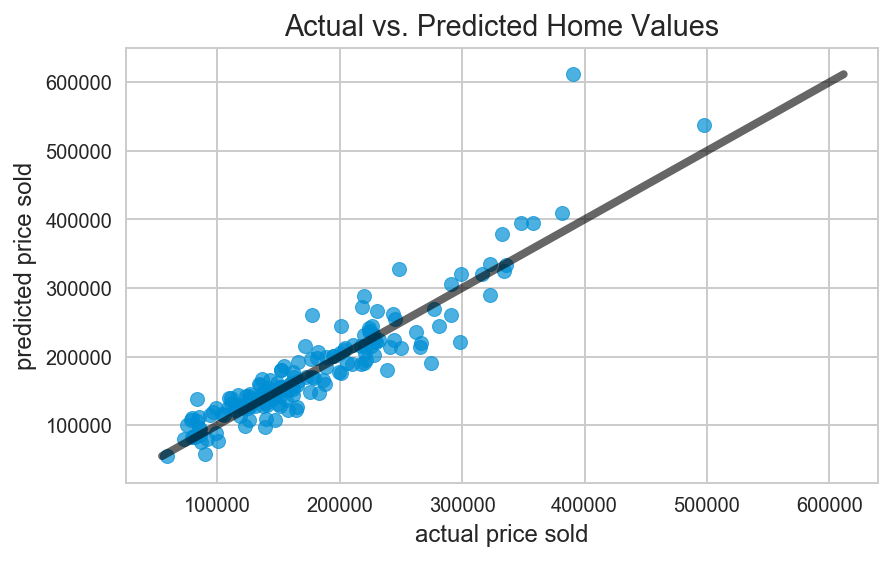

In [60]:
# plot fixed + kitchen model with predictions

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], c = 'k', alpha = .6)
plt.scatter(predicted, y_test, alpha = .7)
plt.xlabel('actual price sold')
plt.ylabel('predicted price sold')
plt.title('Actual vs. Predicted Home Values')

print model.score(X_test, y_test)

### Residuals

0.8551925318


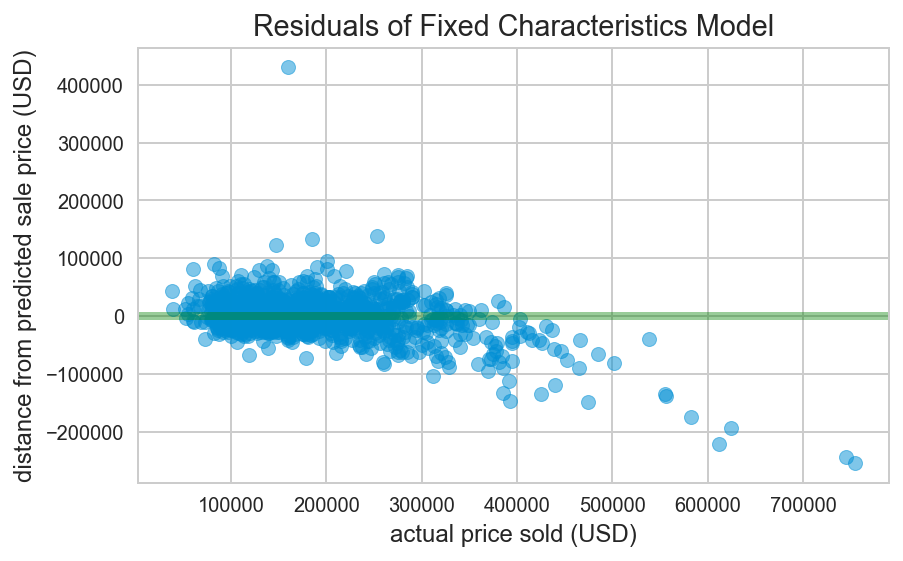

In [63]:
# lasso residuals of all data
resid_kitch_all = model.predict(df_all.drop('SalePrice', axis = 1)) - df_all['SalePrice'].values

plt.axhline(c = 'g', alpha = .4)
plt.scatter(df['SalePrice'], resid_kitch_all, alpha = .5)
plt.title('Residuals of Fixed Characteristics Model')
plt.xlabel('actual price sold (USD)')
plt.ylabel('distance from predicted sale price (USD)')

print model.score(X_test, y_test)

### Conclusions

The r-squared score increased from .82 to .85 when including only the kitchen quality data. That means the kitchen quality explains 19% of the variance of the sale price when only using fixed characteristics.

The Betas, or coefficients, of the Kitchen Quality dummy variable show us how much the expected Sale Price would increase by improving the Kitchen level. Going from a Poor Kitchen to the next levels would increase the Sale Price by:

- Excellent: $65,884.53

- Good: $17,898.30

- Typical / Average $1,878.90

- Fair: $0.00
